# Алгоритм квантовой телепортации

## Реализация на классическом симмуляторе
### Введение
Коротко об идее: хотим передать кубит в состоянии $\psi = a\,\bigl|0\bigr\rangle + b\,\bigl|1\bigr\rangle$ от Бибы к Бобе. Но квантовая механика запрещает это. Однако, пользуясь свойтсвами кубитов, можно один "записать" в другой, причем первый "исчезнет". Этот трюк и называется "Квантовой телепортацией". Весь код нижу рекомендуется запускать поблочно, иначе может исполниться кусок кода, отвечающий за считыввание схемы, и придётся генерировать схему заново, т.к. кубиты локализуются

### Подготовка
Сначала подключим необходимые библиотеки

In [1]:
import numpy as np
from cmath import phase
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import IBMQ, Aer, transpile, assemble
from qiskit.visualization import plot_histogram, plot_bloch_multivector, array_to_latex
from qiskit.extensions import Initialize
from qiskit.quantum_info import random_statevector
from qiskit.quantum_info import Statevector

Создание самой квантовой схемы, а точнее определение кубитов и битов:

In [2]:
qr = QuantumRegister(3, name="q")    # 3 кубита "q"
crz = ClassicalRegister(1, name="crz") # 3 бита
crx = ClassicalRegister(1, name="crx")
cry = ClassicalRegister(1, name="cry")
teleportation_circuit = QuantumCircuit(qr, crz, crx, cry)  #задание схемы по ранеее названным фрагментаа

Если искуственно ничего не положить в кубит $q_0$, от по базовой настройке имеет значение $\bigl|0\bigr\rangle$. Сделаем ввод значения $q_0$

In [3]:
#Начальное состояние кубита выглядит так:psi = A|0> + B|1>, введите коэфициенты А и B через пробел
#print('The initial state of the qubit is:psi = A|0> + B|1>, enter A and B separated by a space')
#A, B = map(complex, input().split())
#while (abs(A))**2 + (abs(B))**2 != 1:
#    print('It should be like this: A^2+B^2=1, enter A and B satisfying the condition') #Должно выполняться условие А^2+B^2=1, введите новые А и В через пробел
#    A, B = map(float, input().split())
#Код ниже созадёт кубит с заданными выше значениями
#initial_state = [A,B]   # Это наши значения из ввода
#teleportation_circuit.initialize(initial_state, 0) # Добавили значения из ввода в q0
#teleportation_circuit.draw('mpl')

Но можно положиться на рандом

In [3]:
#Функция ниже создаёт случайный кубит, отметит её коментарием, вдруг понадобиться в будующем
psi = random_statevector(2)
init_gate = Initialize(psi)
A, B = init_gate.params
teleportation_circuit.append(init_gate, [0])  # Добавили значения из ввода в q0

Создадим функцию для генерации пар Белла

In [4]:
#Создаёт пары Белла в цепи qc на кубитах a и b, причем а -управляющий (важно для CNOT)
def create_bell_pair(qc, a, b):
    qc.h(a)
    qc.cx(a,b)

### Шаг 1: Появление Гудини
Для реализации алгоритма, нам необходима третья сущность - Гудини, которая передаст Бибе и Бобе запутанную пару кубитов (пару Белла). В нашем случае Гудини запутает $q_1$ и $q_2$. Важно заметить, что Биба хочет передать не $q_1$, а кубит, который был у него зараее - $q_0$

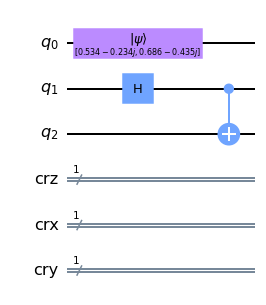

In [5]:
create_bell_pair(teleportation_circuit, 1, 2)

#Сделали довольно много, посмотрим что имеем на данном этапе
teleportation_circuit.draw('mpl') #Значение 'mpl' делает красивую картинку

Допустим Гудини отдал $q_1$ Бибе а $q_2$ Бобе. Начальные данные получены.

### Шаг 2: Операции Бибы
Теперь хотим, чтобы Биба применил гейт CNOT к $q_1$, который будет управляем кубита, который он хочет отправить Бобе (то есть $q_0$ управлящий). Затем применим к $q_0$ гейт Адамара

In [6]:
teleportation_circuit.barrier() #Визуальный барьер на схемы,чтобы различать шаги
teleportation_circuit.cx(0, 1) #Разместили гейт CNOT
teleportation_circuit.h(0) #Разместили гейт Адамара

### Шаг 3: Чтение и отправка данных
Теперь прочитаем оба кубита Бибы, запишем их значения в имеющиеся биты и отправим БИТЫ Бобе (биты, в отличие от кубитов, можно спокойно пересылать, копировать и т.д.)

In [7]:
teleportation_circuit.barrier() #очередной барьер
teleportation_circuit.measure(0,0) #чтение и запись кубитов
teleportation_circuit.measure(1,1)

### Шаг 4: Прием битов, декодировка
Боба, у которого есть кубит q2, в зависимости от значений полученных битов действует на q2 определёнными гейтами

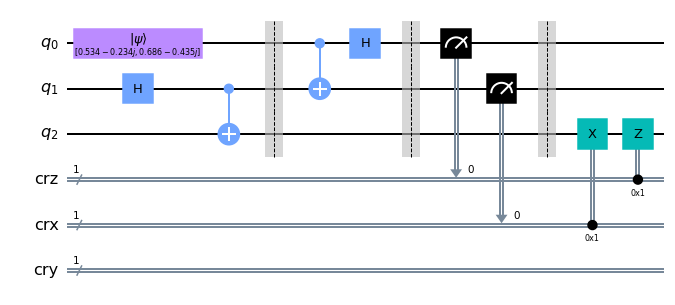

In [8]:
teleportation_circuit.barrier()
teleportation_circuit.x(2).c_if(crx, 1) #c_if - Почки как С'gate' только с битами, имя_цепи.gate(номер_кубита,
                                        #к_которому_применим_gate_если_бит_равен_ЗнАчЕнИю_БиТа)c_if(название_бита, 
                                        #ЗнАчЕнИе_БиТа)
teleportation_circuit.z(2).c_if(crz, 1)
teleportation_circuit.draw('mpl') 

Квантовая схема алгоритма квантовой телепортации готова! Убедимся, что квантовая телепортаия работает

In [10]:
#sim = Aer.get_backend('aer_simulator') #Не вдаваясь в подробности, эта выводит состояния кубитов на сфере Блоха
#teleportation_circuit.save_statevector()
##out_vector = sim.run(teleportation_circuit).result().get_statevector()
#plot_bloch_multivector(out_vector)

Видно, что $q_1$ соответсвует А и В, которые мы ввели руками для $q_0$. Правда, $q_0$ отображён в состоянии 1, но с этим ничего поделать нельзя, потому что его прочитали как 1 (там мог быть и 0, это уже вопрос значения А и В)

###  Gate: $\psi \rightarrow \bigl|0\bigr\rangle$
Была поставлена задача внедрить 2 гейта в 3 кубит, чтобы из любого состояния получать 100% состояние $\bigl|0\bigr\rangle$. Реализуем это путен добавление двух последовательных гейта поворота. Можно использовать два любых различных гейта поворта (или один гейт поворота вокруг произвольно оси), но для удобства используем гейт попрота вокруг оси Z, а затем воркуг оси X.

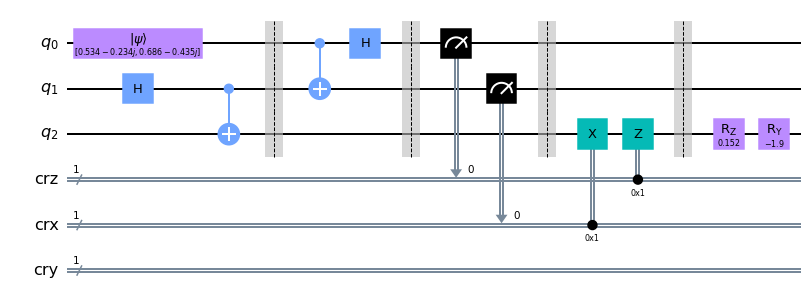

In [9]:
teleportation_circuit.barrier() 
phi = phase(B) - phase(A) # Зная устройство сферы блоха ищём углы, на которые будем поворачивать (обязательно знать коэфициенты)
theta =2*np.arccos(abs(A))
teleportation_circuit.rz(-phi, 2) # Поворот по X на -Ф
teleportation_circuit.ry(-theta, 2) # Поворот по Y на Theta
teleportation_circuit.draw('mpl')

In [12]:
#sim = Aer.get_backend('aer_simulator') #Не вдаваясь в подробности, эта выводит состояния кубитов на сфере Блоха
#teleportation_circuit.save_statevector()
#out_vector = sim.run(teleportation_circuit).result().get_statevector()
#plot_bloch_multivector(out_vector)


Это наглядно показывает, что $q_2$ после прохождения схемы находится в состоянии $\left| 0 \right\rangle$. Но, Т.З. есть Т.З., поэтому код добавить счётчик с $q_2$ на cry. Если до этого шага были кубиты были ввыведены на сферы Блоха, необходимо запустить весь код заново, исключая тот самый вывод сфер.

In [13]:
#teleportation_circuit.barrier() #Барьер
#teleportation_circuit.measure(2,2) #Чтение q_2 на cry
#teleportation_circuit.draw('mpl') 

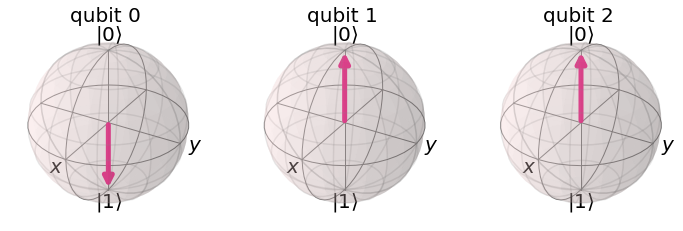

In [10]:
sim = Aer.get_backend('aer_simulator') #Не бдаваясь в подробности, эта выводит состояния кубитов на сфере Блоха
teleportation_circuit.save_statevector()
out_vector = sim.run(teleportation_circuit).result().get_statevector()
plot_bloch_multivector(out_vector)

## Реализация на квантовом компьютере

### Адаптация схемы
К сожалению, на реальных копьютерах IBM нельзя проводить какие-либо операции после изммерения кубита, а это значит, что схема алгоритма квантовой телепортации в том виде, в котором она реализованна выше, не может работать на реальном квантовом компьютере. НО! К счастью существует принцип отложенного действия ("любое измерение можно отложить в конец схемы"), а это значит, что мы можем изменить схему пользуясь этим принципом и уже изменённую схему получится запустить на реальном квантовом компьютере. Этим и займёмся

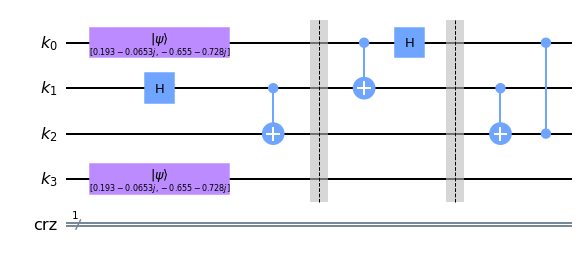

In [11]:
# Здесь мы заново построим схему, заменив чтение кубитов в середине схемы

qr = QuantumRegister(4, name="k")    # 4 кубита "q" (добавил ещё один, чтобы убедиться в правильности телепортации)
crx = ClassicalRegister(1, name="crz") # 1 бита
real_circuit = QuantumCircuit(qr, crx)  #задание схемы по ранеее названным фрагментаа

#Функция ниже создаёт случайный кубит, отметит её коментарием, вдруг понадобиться в будующем
phi = random_statevector(2)
init = Initialize(phi)
A, B = init.params
real_circuit.append(init, [0])  # Добавили значения из ввода в q0
initial_state = [A,B]   # Это наши значения из ввода
real_circuit.initialize(initial_state, 3) # Добавили значения из ввода в q0
    
create_bell_pair(real_circuit, 1, 2) #Созадём пары Белла

real_circuit.barrier() #Визуальный барьер на схемы,чтобы различать шаги
real_circuit.cx(0, 1) #Разместили гейт CNOT
real_circuit.h(0) #Разместили гейт Адамара

real_circuit.barrier() 
real_circuit.cx(1, 2) #Заменим чтение в середение схемы по принципу отложенного чтения
real_circuit.cz(0, 2) 

real_circuit.draw('mpl')

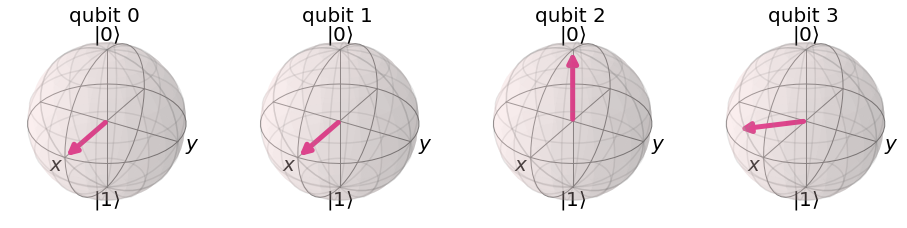

In [22]:
sim = Aer.get_backend('aer_simulator') #Не вдаваясь в подробности, эта выводит состояния кубитов на сфере Блоха
real_circuit.save_statevector()
out_vector = sim.run(real_circuit).result().get_statevector()
plot_bloch_multivector(out_vector)

Как видно выше, алгоритм телефортации работает исправно, теперь доделаем вывод всегда в состояние $\left| 0 \right\rangle$

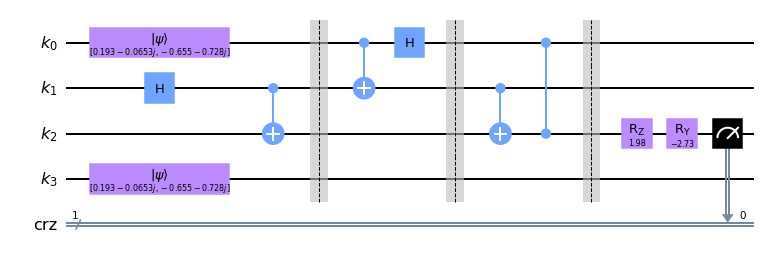

In [12]:
real_circuit.barrier() # Сгенериуем схему заново, если ло этого вывели сферы
phi = phase(B) - phase(A) # Зная устройство сферы блоха ищём углы, на которые будем поворачивать (обязательно знать коэфициенты)
theta =2*np.arccos(abs(A))
real_circuit.rz(-phi, 2) # Поворот по X на -Ф
real_circuit.ry(-theta, 2) # Поворот по Y на Theta

real_circuit.measure(2,0)

real_circuit.draw('mpl')

### Запуск на удалённом квантовом компьютере


In [13]:
from qiskit.providers.ibmq import least_busy #Подключим необходимые модули
from qiskit.tools.monitor import job_monitor
IBMQ.load_account() #Вход в аккаунт IBM, перед этим нужно залогинится на устройстве командой: IBMQ.save_account('свой_ID')
provider = IBMQ.get_provider(hub='ibm-q')

In [14]:

# Найдcём сервер в IBM и запустиим там схему real_circuit  
backend = least_busy(provider.backends(filters=lambda b: b.configuration().n_qubits >= 3 and
                                   not b.configuration().simulator and b.status().operational==True))
t_qc = transpile(real_circuit, backend, optimization_level=3)
job = backend.run(t_qc)
job_monitor(job)  # отображает статус задания в ячейке ниже (придётся подожать в очереди=) )

Job Status: job has successfully run


{'0': 3571, '1': 429}


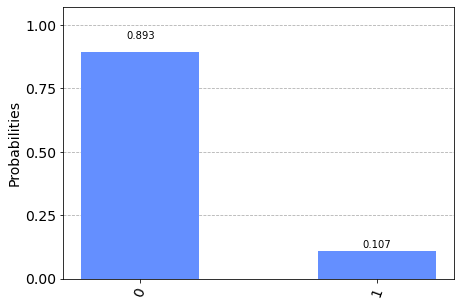

In [15]:
exp_result = job.result()
exp_counts = exp_result.get_counts(real_circuit)
print(exp_counts)
plot_histogram(exp_counts)

Как и ожидалось, чистого нуля не будет, т.к. квантовый компьютер допускает ошибки при моделировании в гйетах и кубитах